In [109]:
import jax
from jax.config import config
config.update("jax_enable_x64", True)

In [110]:
import scanpy as sc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import moscot
from moscot.problems.time import TemporalProblem
import moscot.plotting as mpl

In [111]:
adata = sc.read_h5ad("/lustre/groups/ml01/workspace/moscot_paper/pancreas/pancreas_multiome_2022_multiVI_embedding.h5ad")

In [112]:
endocrine_celltypes = [
    "Ductal",
    "Prlf. Ductal",
    "Ngn3 low",
    "Ngn3 high",
    "Ngn3 high cycling",
    "Fev+",
    "Fev+ Alpha",
    "Fev+ Beta",
    "Fev+ Delta",
    "Eps/Delta progenitors",
    "Alpha",
    "Beta",
    "Delta",
    "Epsilon"
]

In [113]:
adata_red = adata[adata.obs["celltype"].isin(endocrine_celltypes)]

In [114]:
adata_removed = adata[~adata.obs["celltype"].isin(endocrine_celltypes)]

In [115]:
adata_removed.obs["celltype"].cat.categories

Index(['Imm. Acinar', 'Mat. Acinar'], dtype='object')

In [116]:
adata_red.obs["celltype"].cat.categories

Index(['Alpha', 'Beta', 'Delta', 'Ductal', 'Eps/Delta progenitors', 'Epsilon',
       'Fev+', 'Fev+ Alpha', 'Fev+ Beta', 'Fev+ Delta', 'Ngn3 high',
       'Ngn3 high cycling', 'Ngn3 low', 'Prlf. Ductal'],
      dtype='object')

In [117]:
adata = adata_red.copy()

In [118]:
adata.obs['time'] = adata.obs.apply(lambda x: 14.5 if x["sample"]=="E14.5" else 15.5, axis=1)

In [119]:
sc.tl.umap(adata)

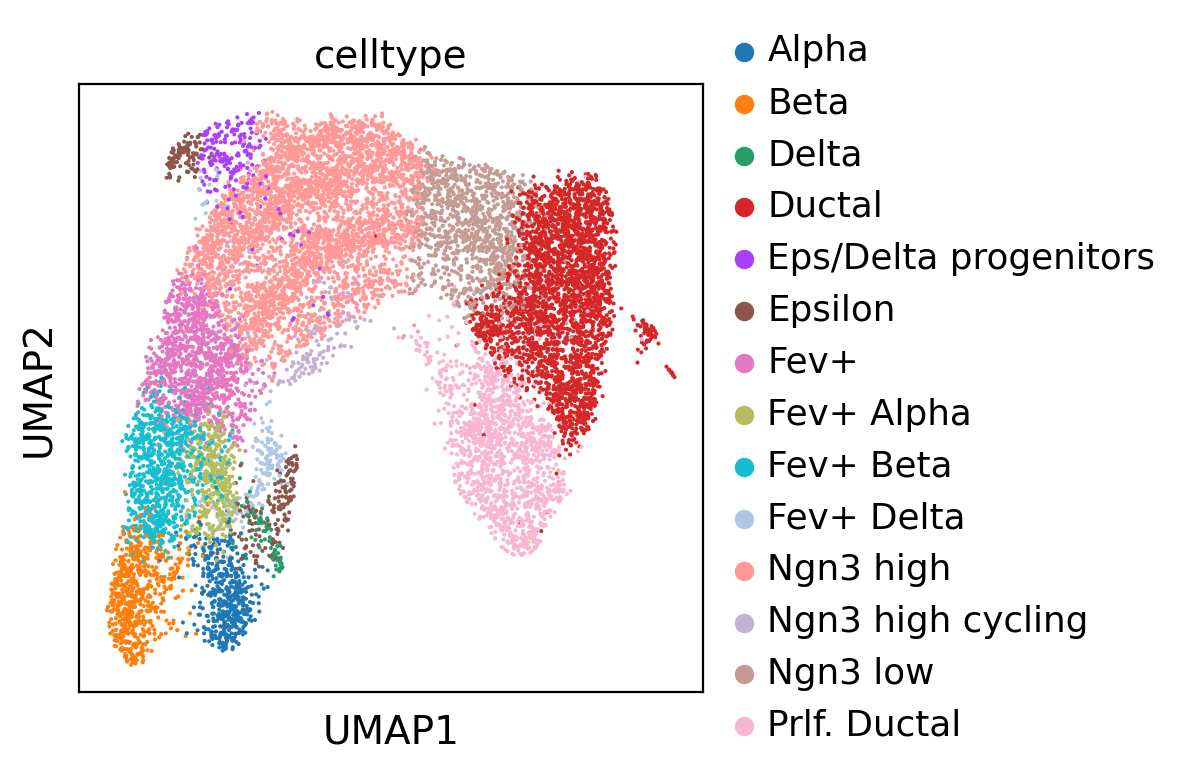

In [120]:
sc.pl.umap(adata, color="celltype")

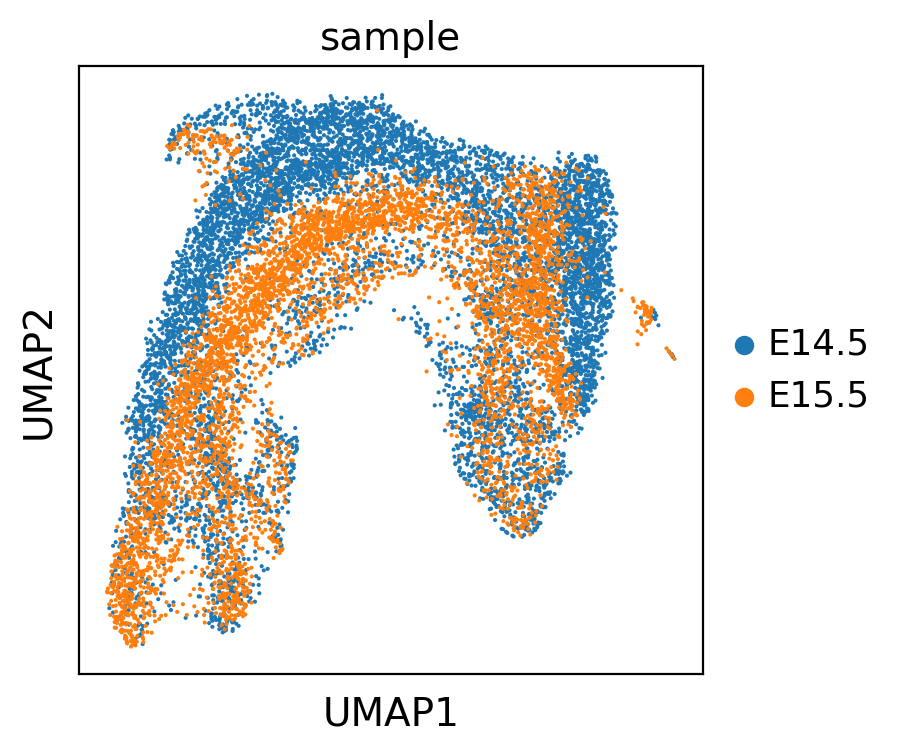

In [121]:
sc.pl.umap(adata, color="sample")

In [122]:
tp0 = TemporalProblem(adata)
tp0 = tp0.prepare("time", joint_attr="X_multi_vi")

In [123]:
tp0 = tp0.solve(epsilon=1e-2, scale_cost="mean")

In [124]:
tp0.pull(14.5, 15.5, data="celltype", subset="Delta")

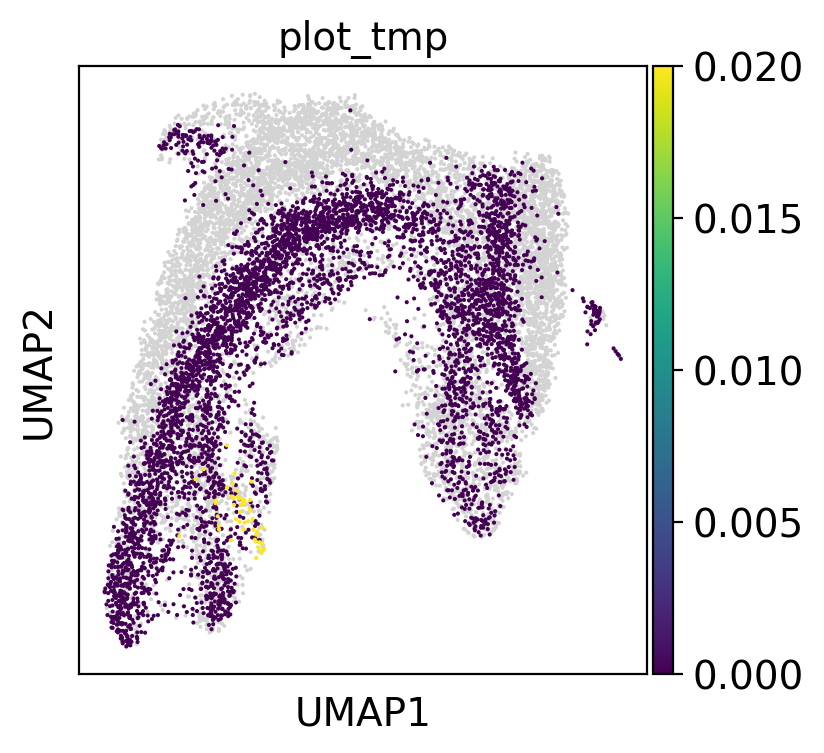

In [125]:
mpl.pull(tp0, time_points=[15.5])

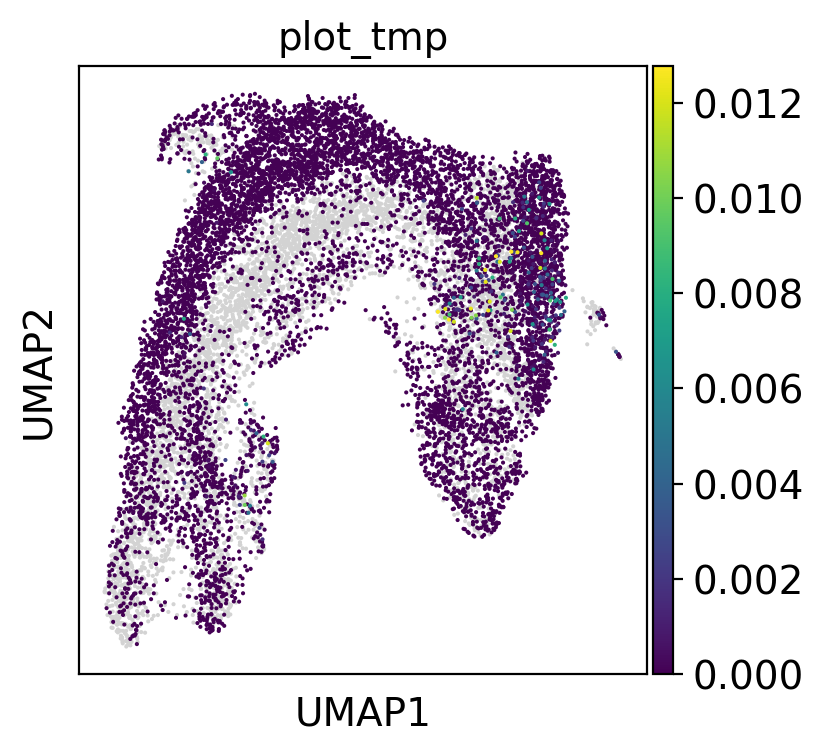

In [126]:
mpl.pull(tp0, time_points=[14.5])

In [127]:
adata_red = adata[adata.obs["celltype"]=="Fev+ Delta"]

In [128]:
adata_red[adata_red.obs["pull"]==adata_red.obs["pull"].max()].obs

batch_id modality  _scvi_batch    celltype sample  time  \
AAAGCACCAAGGTACG-1-0         1   paired            0  Fev+ Delta  E14.5  14.5   

                          pull  plot_tmp  
AAAGCACCAAGGTACG-1-0  0.008312  0.008312

In [129]:
adata.obs["index"] = adata.obs.index

In [130]:
def fill(x):
    if x["index"] == "AAAGCACCAAGGTACG-1-0":
        return 1
    return 0

In [131]:
adata.obs["to_augment"] = adata.obs.apply(fill, axis=1)

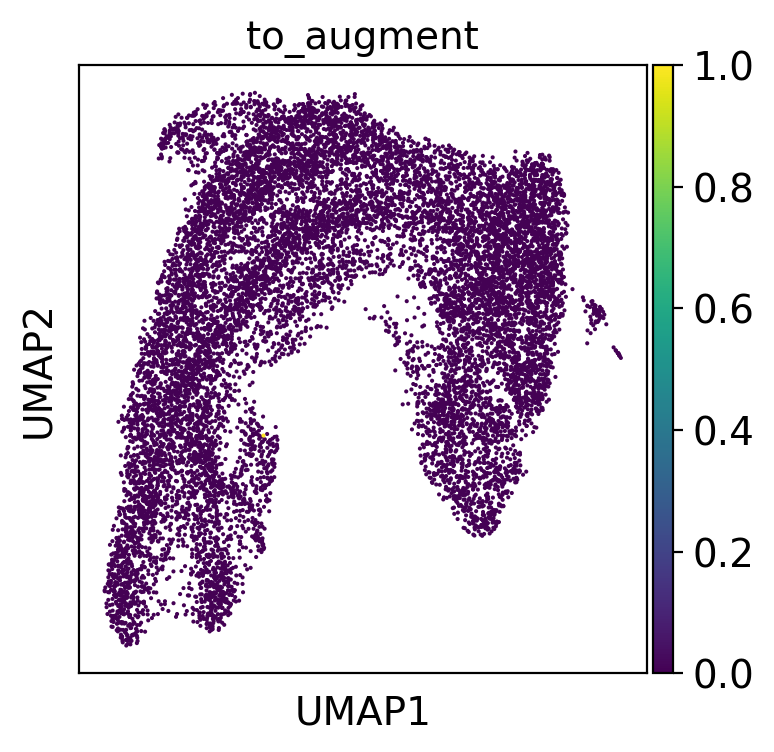

In [56]:
sc.pl.umap(adata, color="to_augment")

In [57]:
adata_to_augment = adata[adata.obs["index"]=="AAAGCACCAAGGTACG-1-0"]

In [60]:
adatas = [adata_to_augment.copy() for i in range(50)]

In [62]:
dim = adata.obsm["X_multi_vi"].shape[1]

In [63]:
mean = np.zeros(dim)

In [64]:
cov = 0.001 * np.diag(np.ones(dim))

In [71]:
for ad in adatas:
    ad.obsm["X_multi_vi"] = adata_to_augment.obsm["X_multi_vi"] + np.random.multivariate_normal(mean, cov)

In [72]:
import anndata
bdata = anndata.concat([adata]+adatas)

/home/icb/dominik.klein/miniconda3/envs/jax_gpu2/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [73]:
sc.pp.neighbors(bdata)

In [74]:
sc.tl.umap(bdata)

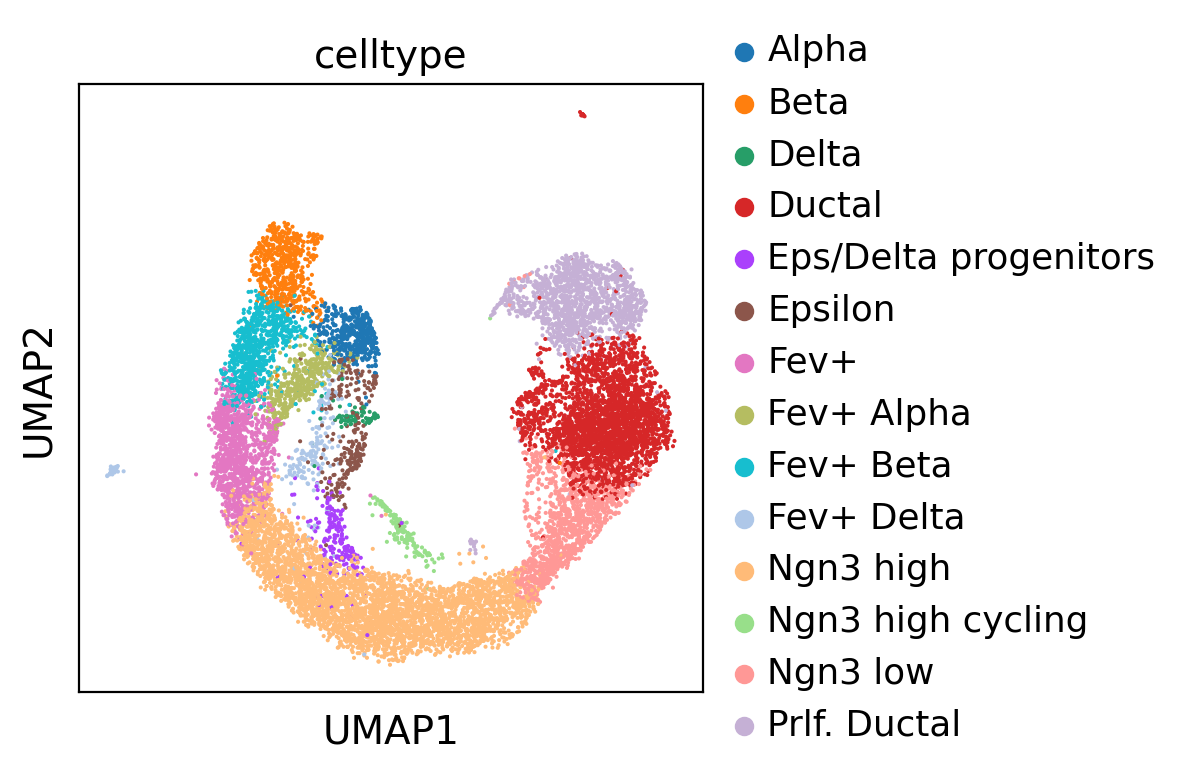

In [75]:
sc.pl.umap(bdata, color="celltype")

In [136]:
len(bdata[bdata.obs["celltype"]=="Delta"]), len(adata[adata.obs["celltype"]=="Delta"])

(77, 77)

In [137]:
len(bdata[bdata.obs["celltype"]=="Fev+ Delta"]), len(adata[adata.obs["celltype"]=="Fev+ Delta"])

(226, 176)

In [77]:
tp1= TemporalProblem(bdata)
#tp0 = tp0.score_genes_for_marginals(gene_set_proliferation="mouse", gene_set_apoptosis="mouse")
tp1 = tp0.prepare("time", joint_attr="X_multi_vi")

In [78]:
tp1 = tp1.solve(epsilon=1e-2, scale_cost="mean")

In [81]:
tp1[14.5, 15.5].solution.converged

True

In [92]:
ct_desc = tp1.cell_transition(start=14.5, end=15.5, early_annotation="celltype", late_annotation="celltype", forward=True)

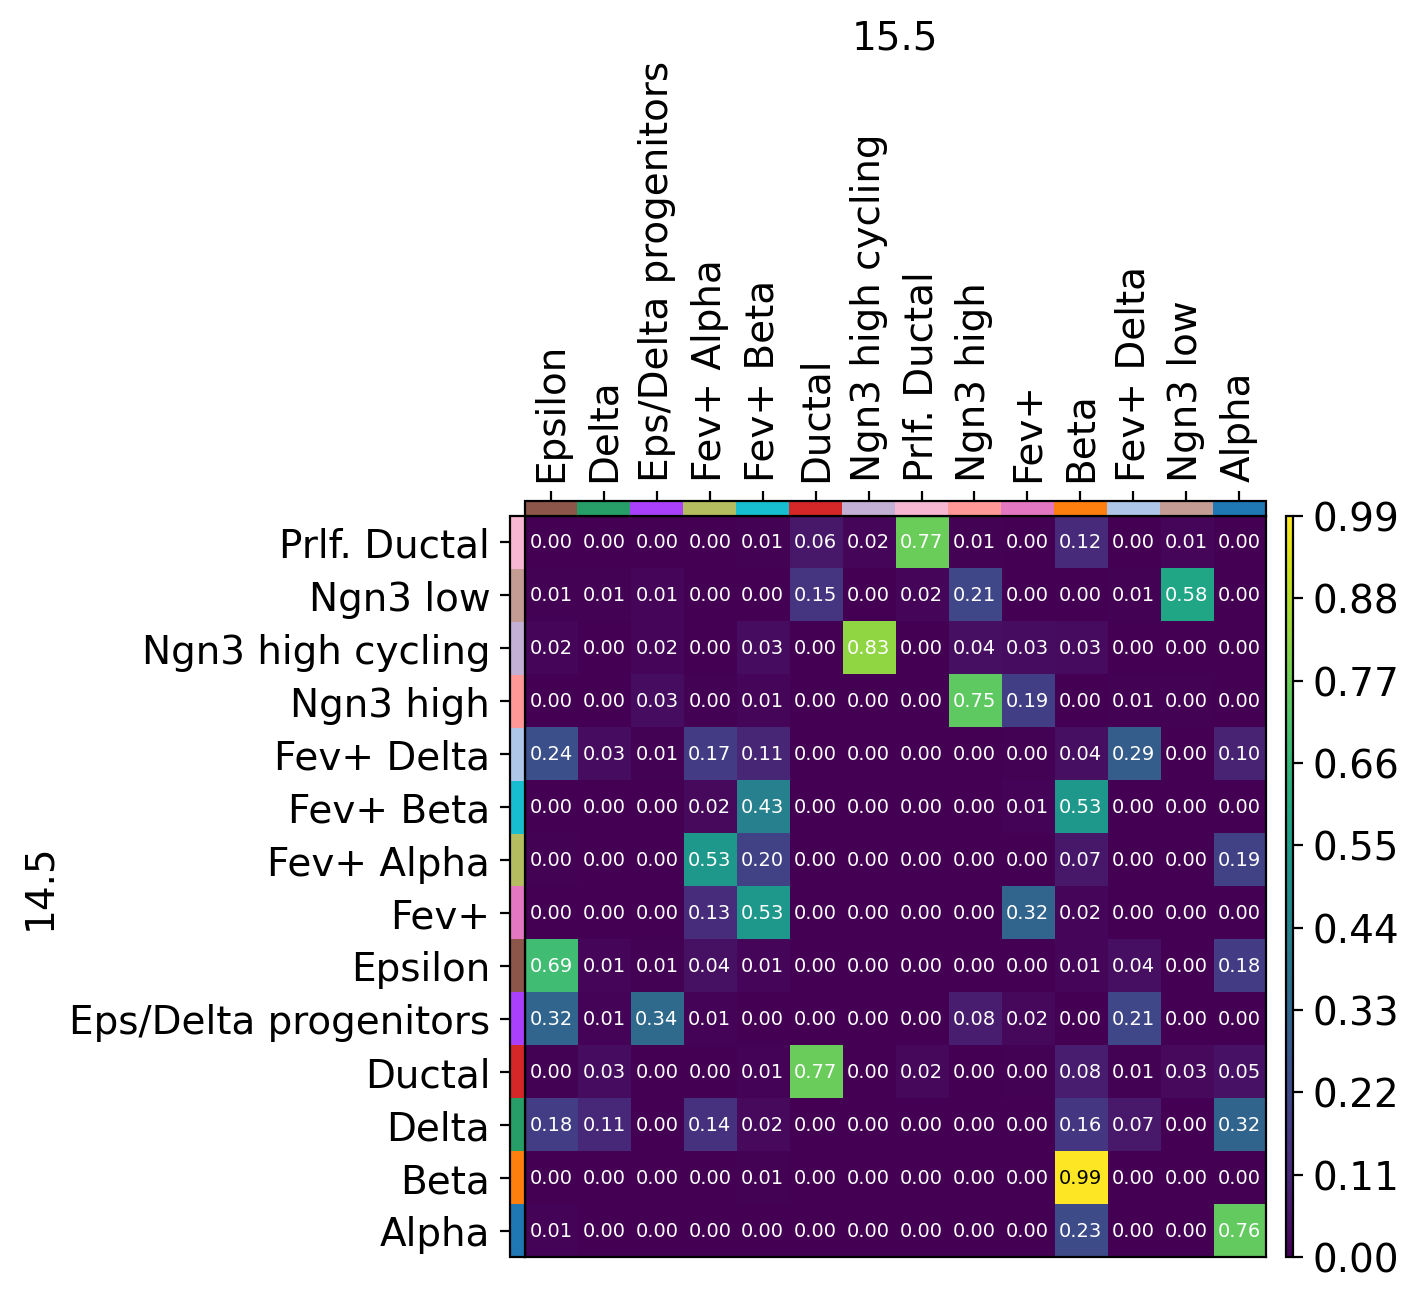

In [93]:
mpl.cell_transition(tp1, dpi=100, fontsize=7)

In [96]:
ct_desc = tp1.cell_transition(start=14.5, end=15.5, early_annotation="celltype", late_annotation="celltype", forward=False)

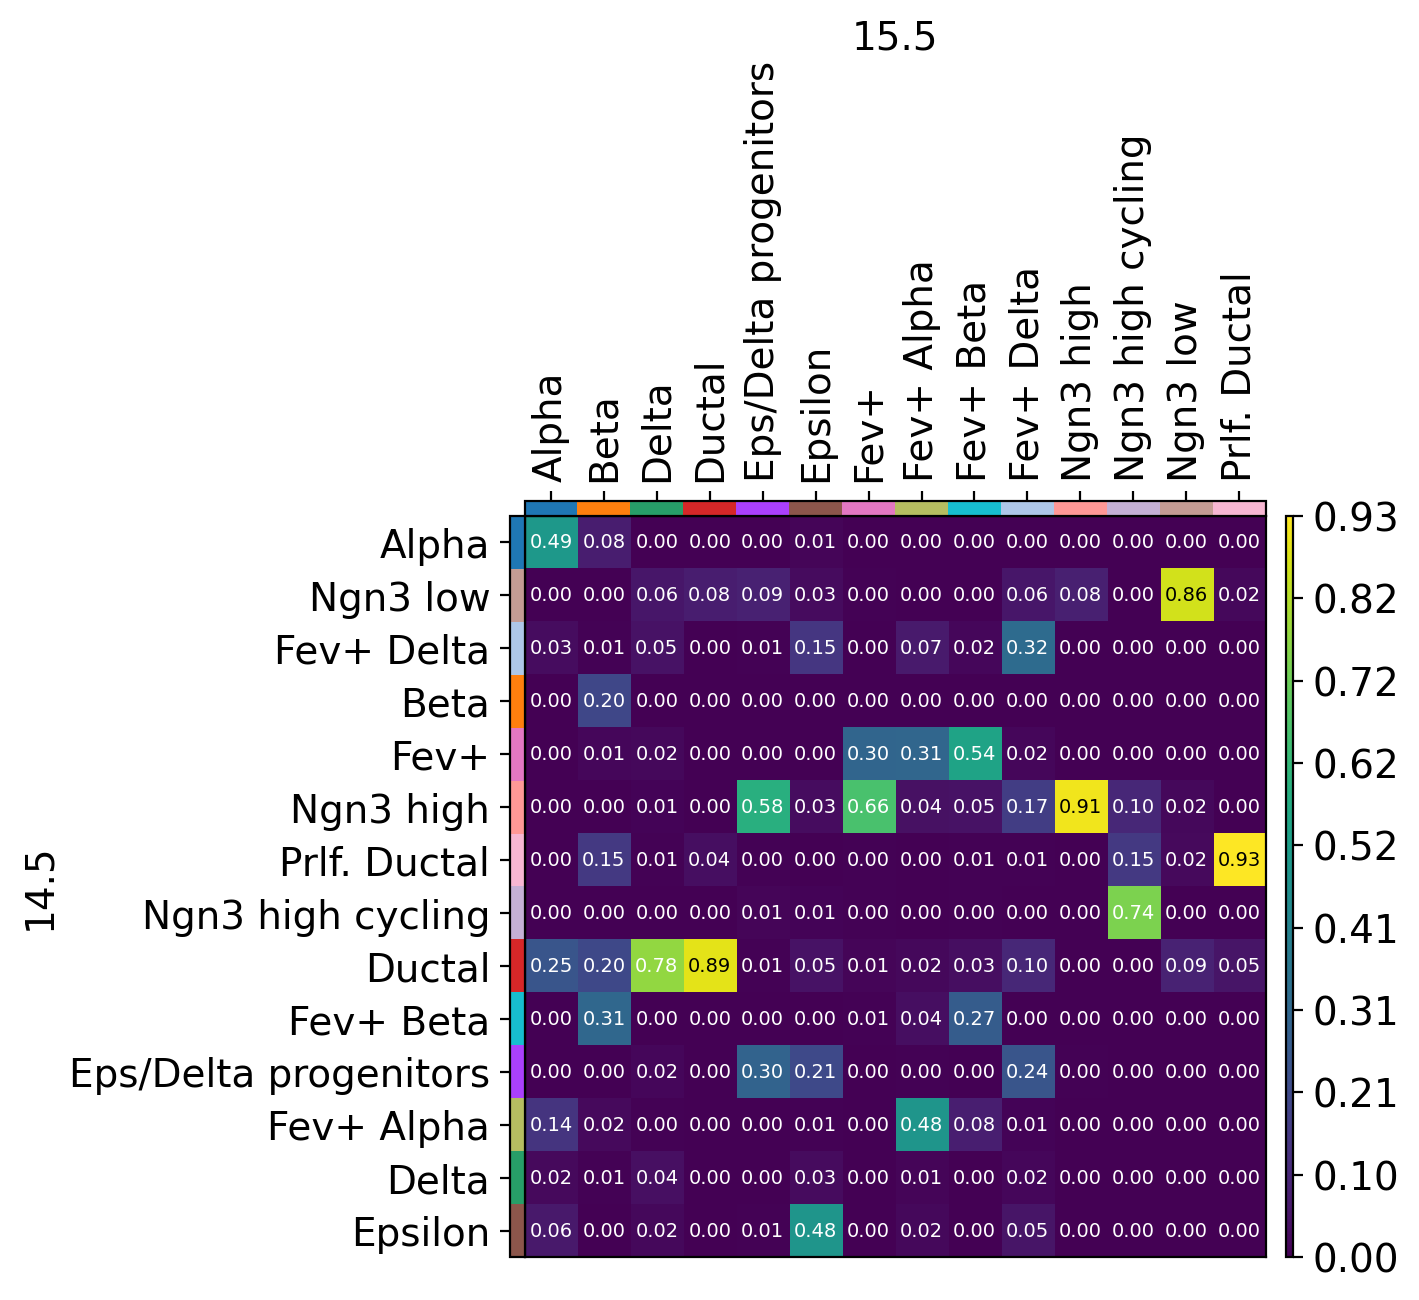

In [97]:
mpl.cell_transition(tp1, dpi=100, fontsize=7)

In [100]:
tp1.pull(14.5, 15.5, data="celltype", subset="Delta")

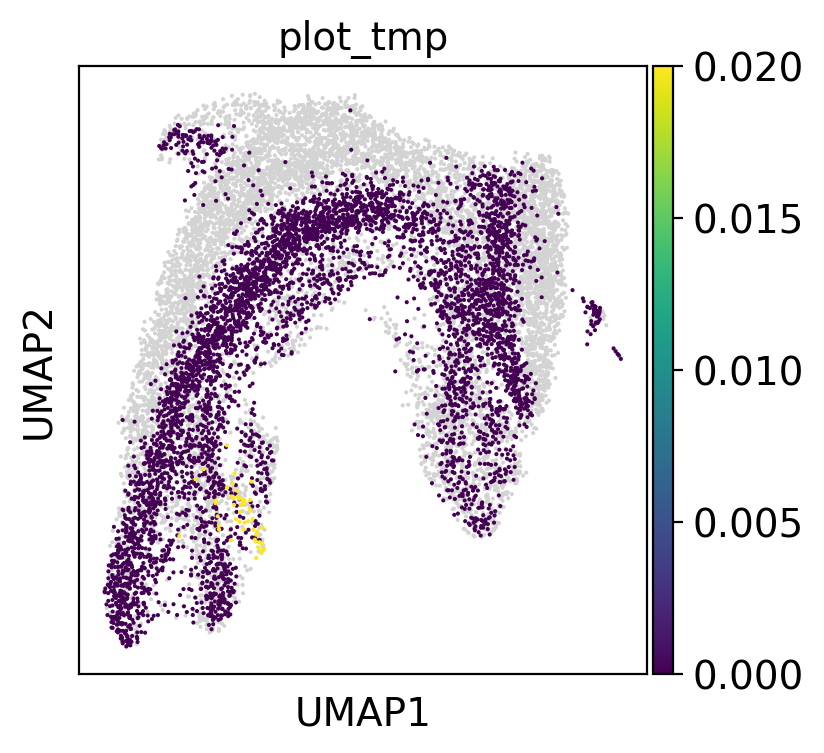

In [101]:
mpl.pull(tp1, time_points=[15.5])

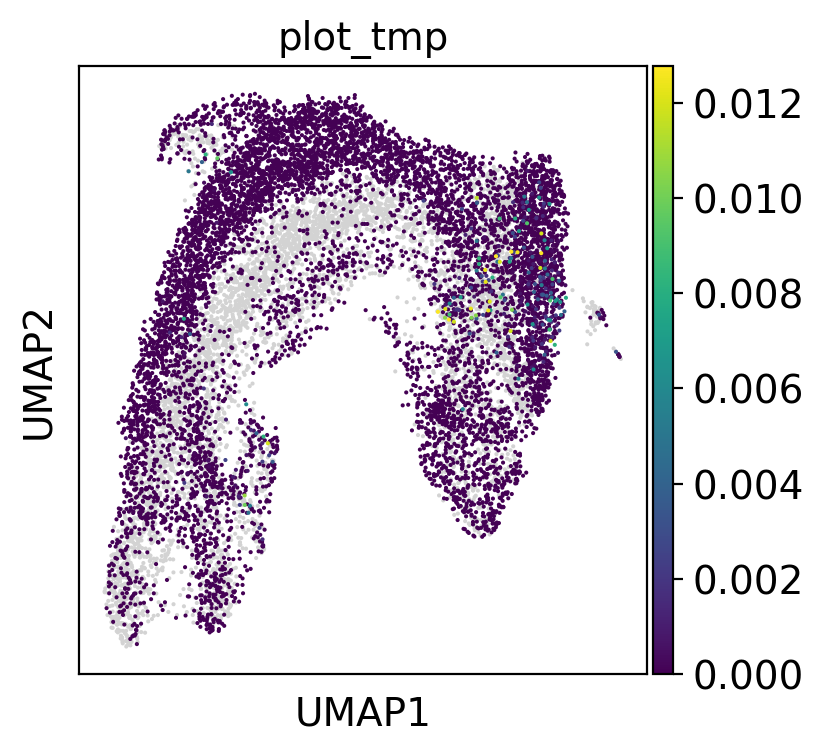

In [102]:
mpl.pull(tp1, time_points=[14.5])

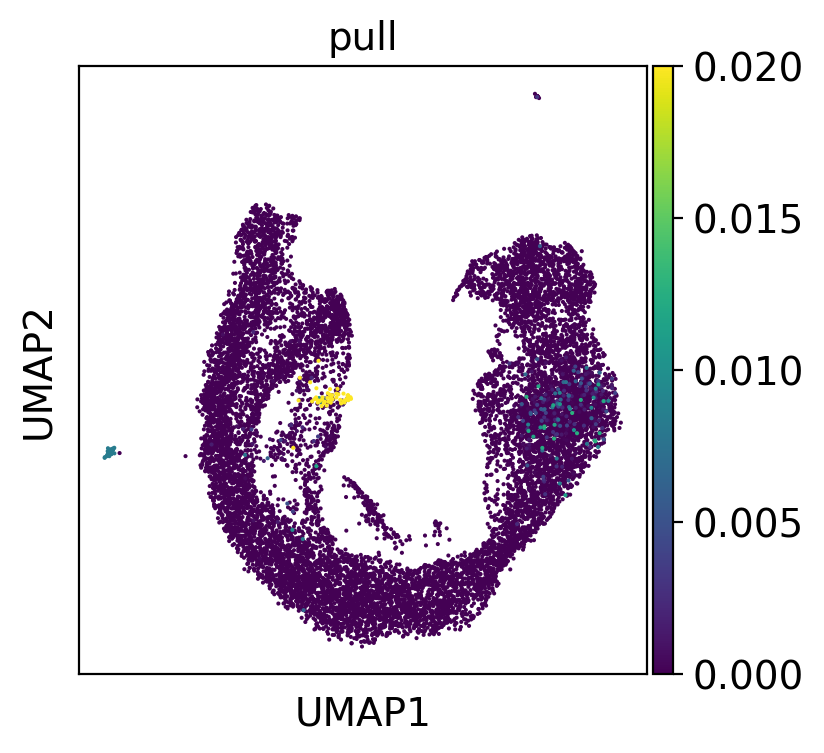

In [105]:
sc.pl.umap(bdata, color="pull")

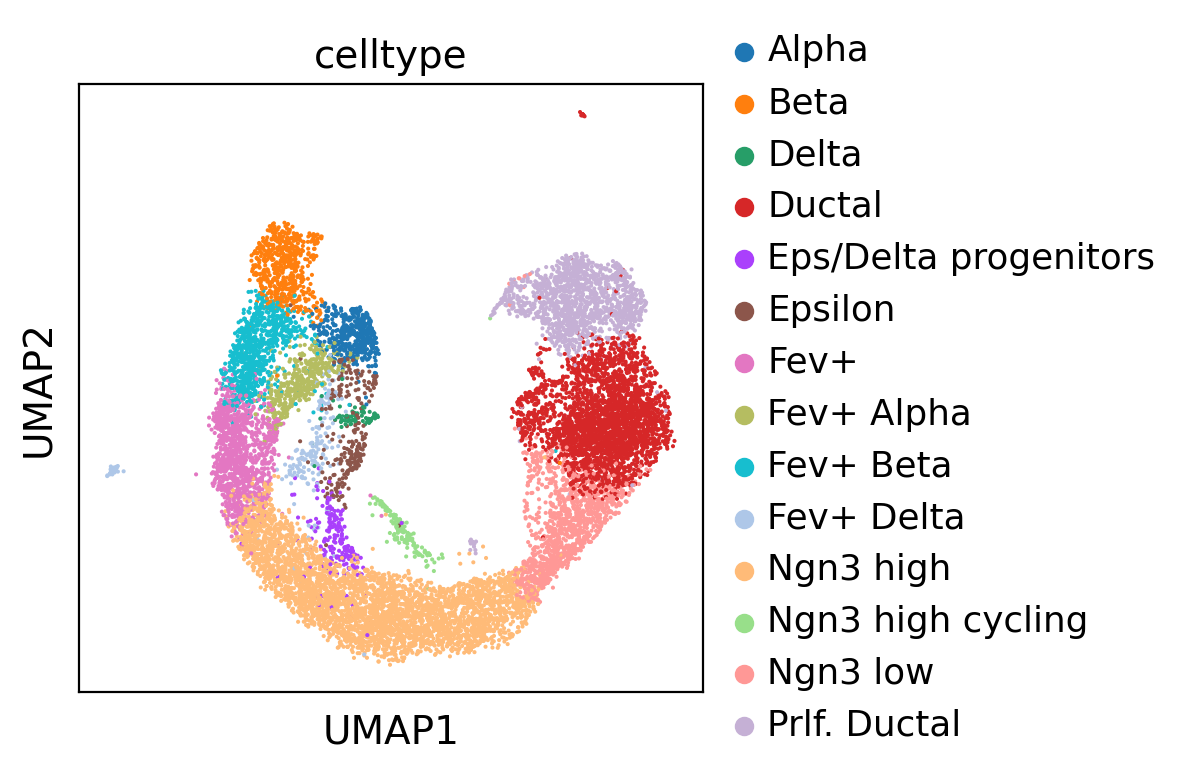

In [108]:
sc.pl.umap(bdata, color="celltype")